# Project Description: 

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.Build a model with the maximum possible F1 score. To pass the project, you need an F1 score of at least 0.59. Check the F1 for the test set.Additionally, measure the AUC-ROC metric and compare it with the F1.

## Import Libraries and Prepare Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the data and print 5 rows
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#checking information and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
#checking for missing values 
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

There are 909 blanks in tenure column. I will replace those missing values with tenure's mean.

In [5]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].mean())

In [6]:
#change Tenure column from float to int to be consistent with NumOfProducts, HasCrCard, & IsActiveMember
df['Tenure'] = df['Tenure'].astype(int)

#checking to see if Tenure has the correct datatype now
df['Tenure'].dtype

dtype('int64')

In [7]:
#dopping unnecessary columns: RowNumber, CustomerId, Surname
df = df.drop(['RowNumber','CustomerId','Surname'], axis = 1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
#One-hot encode the dataframe: transforming categorical features into numerical 
df_ohe = pd.get_dummies(df, drop_first = True)

#creating features and target
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

#splitting the data 
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.2, random_state=12345 )

7963
2037


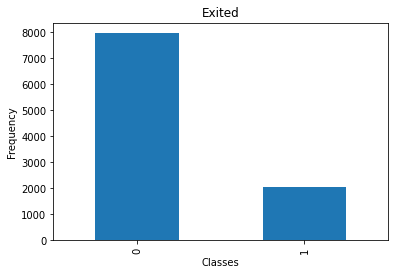

In [9]:
#checking the classes balance: 
print(df[df['Exited']==0]['Exited'].count())
print(df[df['Exited']==1]['Exited'].count())

#plotting the classes
target = pd.value_counts(df['Exited'], sort=True)
target.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Exited')
plt.show()

There is a class imbalance. Class "0" has a higher frequency than class "1".

## Train Models w/ imbalanced classses

In [10]:
#standardize the features
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train.loc[:,numeric] = scaler.transform(features_train[numeric])
features_valid.loc[:,numeric] = scaler.transform(features_valid[numeric])
features_test.loc[:,numeric] = scaler.transform(features_test[numeric])

In [11]:
#train a logisticRegresison model
logistic_model = LogisticRegression(random_state=12345, solver='liblinear')
logistic_model.fit(features_train, target_train)
predicted_valid = logistic_model.predict(features_valid)
probabilities_valid = logistic_model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('Accuracy score:', accuracy_score(target_valid, predicted_valid))
print('F1 score:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Accuracy score: 0.8175
F1 score: 0.3145539906103286
AUC-ROC: 0.7634576873261729


With the logistic regression model with the imbalanced class, the accuracy score, F1 score, and AUC-ROC score is 0.81, 0.31, 0.76, respectively. 

In [12]:
#decision tree model 
decision_model = DecisionTreeClassifier(random_state=12345)
decision_model.fit(features_train, target_train)
predicted_valid = decision_model.predict(features_valid)
probabilities_valid = decision_model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('Accuracy score:', accuracy_score(target_valid, predicted_valid))
print('F1 score:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Accuracy score: 0.791875
F1 score: 0.46203554119547663
AUC-ROC: 0.6692812303589649


With the decision tree model with the imbalanced class, the accuracy score, F1 score and AUC-ROC score is 0.79, 0.46, and 0.66, respectively. Its F1 score is higher than logistic regression model but it has a lower AUC-ROC score. Because its F1 score is evidently higher than logistic regression model, we can say the decision tree model has a higher accuracy. 

In [13]:
#random forest model 
random_model = RandomForestClassifier(random_state=12345)
random_model.fit(features_train, target_train)
predicted_valid = random_model.predict(features_valid)
probabilities_valid = random_model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('Accuracy score:', accuracy_score(target_valid, predicted_valid))
print('F1 score:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Accuracy score: 0.86625
F1 score: 0.563265306122449
AUC-ROC: 0.8488031532528735


With the random forest model with the imbalanced class, the accuracy score, F1 score and AUC-ROC score is 0.86, 0.56, and 0.84, respectively. Its F1, accuracy and auc-roc score is higher than logistic regression  and decision tree models. With an imbalanced class, the random forest model yields the best result with its highest accuracy. Lets see if the result is different when the class is balanced.

## Train model with balanced classes

# Logistic Model

In [14]:
#train a logisticRegresison model
logistic_model_b = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
logistic_model_b.fit(features_train, target_train)
predicted_valid = logistic_model_b.predict(features_valid)
probabilities_valid = logistic_model_b.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('Accuracy score:', accuracy_score(target_valid, predicted_valid))
print('F1 score:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Accuracy score: 0.70875
F1 score: 0.46924829157175396
AUC-ROC: 0.7666587784453079


When balanced the classes, the accuracy score of logistic regression decreases but the f_1 score and AUC-ROC score improve. 

In [15]:
#decision model 
for depth in range(1,11):
    decision_model_b = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth)
    decision_model_b.fit(features_train, target_train)
    predicted_valid = decision_model_b.predict(features_valid)
    probabilities_valid = decision_model_b.predict_proba(features_valid)
    probablities_one_valid = probabilities_valid[:,1]
    print('Max Depth: ',depth,'F1 score:', f1_score(target_valid, predicted_valid))
    print('Max Depth: ',depth, 'AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Max Depth:  1 F1 score: 0.47058823529411764
Max Depth:  1 AUC-ROC: 0.6914954795402439
Max Depth:  2 F1 score: 0.5006075334143378
Max Depth:  2 AUC-ROC: 0.7476952398400982
Max Depth:  3 F1 score: 0.5006075334143378
Max Depth:  3 AUC-ROC: 0.7991786071436751
Max Depth:  4 F1 score: 0.525030525030525
Max Depth:  4 AUC-ROC: 0.8207528925598805
Max Depth:  5 F1 score: 0.5445544554455446
Max Depth:  5 AUC-ROC: 0.8316437272100379
Max Depth:  6 F1 score: 0.5588972431077694
Max Depth:  6 AUC-ROC: 0.8225455544783468
Max Depth:  7 F1 score: 0.5477075588599752
Max Depth:  7 AUC-ROC: 0.8093531404027065
Max Depth:  8 F1 score: 0.5449936628643853
Max Depth:  8 AUC-ROC: 0.7841731744492877
Max Depth:  9 F1 score: 0.5269922879177379
Max Depth:  9 AUC-ROC: 0.7588710682941848
Max Depth:  10 F1 score: 0.5202614379084968
Max Depth:  10 AUC-ROC: 0.7526928097590022


Compared to the unbalanced decision tree, the balanced decision tree has a higher f_1 and auc-roc score overall. Its scores are also higher than balanced logistic regression model. F_1 score is highest at max_depth = 6 with one of the highest score for auc-roc score. 


In [16]:
# Random Forest model
for depth in range(1, 11):
        random_model_b = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=20, max_depth = depth)
        random_model_b.fit(features_train, target_train)
        predicted_valid = random_model_b.predict(features_valid)
        probabilities_valid = random_model_b.predict_proba(features_valid)
        probablities_one_valid = probabilities_valid[:,1]
        print('Max Depth: ',depth,'F1 score:', f1_score(target_valid, predicted_valid))
        print('Max Depth: ',depth, 'AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Max Depth:  1 F1 score: 0.5183312262958281
Max Depth:  1 AUC-ROC: 0.7881045621909917
Max Depth:  2 F1 score: 0.5260545905707196
Max Depth:  2 AUC-ROC: 0.809429478028759
Max Depth:  3 F1 score: 0.5427509293680297
Max Depth:  3 AUC-ROC: 0.8281690929308814
Max Depth:  4 F1 score: 0.5582010582010581
Max Depth:  4 AUC-ROC: 0.8359377186754912
Max Depth:  5 F1 score: 0.5588235294117647
Max Depth:  5 AUC-ROC: 0.8467458542307584
Max Depth:  6 F1 score: 0.5640326975476839
Max Depth:  6 AUC-ROC: 0.843762325345873
Max Depth:  7 F1 score: 0.5669957686882934
Max Depth:  7 AUC-ROC: 0.8487662567336148
Max Depth:  8 F1 score: 0.5640287769784172
Max Depth:  8 AUC-ROC: 0.8484112867724706
Max Depth:  9 F1 score: 0.6021840873634946
Max Depth:  9 AUC-ROC: 0.8500016539818978
Max Depth:  10 F1 score: 0.5962145110410095
Max Depth:  10 AUC-ROC: 0.8459761165013957


Random tree has a higher accuracy and auc-roc scores than logistic regression and decision tree. Its best max_depth = 9 with f_1 score of 0.60 and AU-ROC of 0.85. It's the only model that satistifes the f_1 score of at least 0.59. 

## Upsampling: 

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [18]:
#logistic regression model 
logistic_model_u = LogisticRegression(random_state=12345, solver='liblinear')
logistic_model_u.fit(features_upsampled, target_upsampled)
predicted_valid = logistic_model_u.predict(features_valid)
probabilities_valid = logistic_model_u.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('F1 score:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

F1 score: 0.39332870048644897
AUC-ROC: 0.7678598237618673


With upsampling, the logistic regression model has a f1 score of 0.39 and AUC-ROC score of 0.76. Its AUC-ROC score is smiliar to the balanced and unbalanced logistic regression model, but its F1 score is smaller.  

In [19]:
#decision tree model
for depth in range(1,11):
    decision_model_u = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    decision_model_u.fit(features_upsampled, target_upsampled)
    predicted_valid = decision_model_u.predict(features_valid)
    probabilities_valid = decision_model_u.predict_proba(features_valid)
    probablities_one_valid = probabilities_valid[:,1]
    print('Max Depth: ',depth,'F1 score:', f1_score(target_valid, predicted_valid))
    print('Max Depth: ',depth, 'AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Max Depth:  1 F1 score: 0.3184445612191277
Max Depth:  1 AUC-ROC: 0.701401558814324
Max Depth:  2 F1 score: 0.3922691481746599
Max Depth:  2 AUC-ROC: 0.7522996709848317
Max Depth:  3 F1 score: 0.41299638989169674
Max Depth:  3 AUC-ROC: 0.8022639195299638
Max Depth:  4 F1 score: 0.4895359417652411
Max Depth:  4 AUC-ROC: 0.8204068286551092
Max Depth:  5 F1 score: 0.45537948290241875
Max Depth:  5 AUC-ROC: 0.8345203834184497
Max Depth:  6 F1 score: 0.4594363791631084
Max Depth:  6 AUC-ROC: 0.8344962098368667
Max Depth:  7 F1 score: 0.46167883211678834
Max Depth:  7 AUC-ROC: 0.799070462173434
Max Depth:  8 F1 score: 0.44424131627056673
Max Depth:  8 AUC-ROC: 0.7672465781659121
Max Depth:  9 F1 score: 0.44083969465648853
Max Depth:  9 AUC-ROC: 0.748592206946215
Max Depth:  10 F1 score: 0.449531737773153
Max Depth:  10 AUC-ROC: 0.7526470071833706


Max_depth = 4 gives the best F1 and AU-ROC scores of .48 and .82, respectively. The F1 and au-roc score is higher than the logistic regression of the upsampled data. It has a smaller f1 score than the unbalanced and balanced decision tree models.

In [20]:
#random forest model
for depth in range(1, 11):
        random_model_u = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth = depth)
        random_model_u.fit(features_upsampled, target_upsampled)
        predicted_valid = random_model_u.predict(features_valid)
        probabilities_valid = random_model_u.predict_proba(features_valid)
        probablities_one_valid = probabilities_valid[:,1]
        print('Max Depth: ',depth,'F1 score:', f1_score(target_valid, predicted_valid))
        print('Max Depth: ',depth, 'AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Max Depth:  1 F1 score: 0.3184445612191277
Max Depth:  1 AUC-ROC: 0.7844874310098704
Max Depth:  2 F1 score: 0.3184445612191277
Max Depth:  2 AUC-ROC: 0.8104854818558186
Max Depth:  3 F1 score: 0.35693039857227843
Max Depth:  3 AUC-ROC: 0.8271576193856857
Max Depth:  4 F1 score: 0.40082361015785856
Max Depth:  4 AUC-ROC: 0.8418335279942798
Max Depth:  5 F1 score: 0.42406015037593975
Max Depth:  5 AUC-ROC: 0.85151695585904
Max Depth:  6 F1 score: 0.43545878693623635
Max Depth:  6 AUC-ROC: 0.8518604751762763
Max Depth:  7 F1 score: 0.45865302642796246
Max Depth:  7 AUC-ROC: 0.8513693697820054
Max Depth:  8 F1 score: 0.4737327188940092
Max Depth:  8 AUC-ROC: 0.8462203969047637
Max Depth:  9 F1 score: 0.4990059642147118
Max Depth:  9 AUC-ROC: 0.8441452857699031
Max Depth:  10 F1 score: 0.5190839694656488
Max Depth:  10 AUC-ROC: 0.8407813410485228


Max depth = 10 gives the random forest model the best f_1 score of 0.51 but max depth = 6 gives the best auc-roc score of .85. It has the best scores of all the upsampled models but it has the lowest score when compares to unbalanced and balanced random forest models.

In [21]:
def downsample(features, target, fraction): 
    features_zeros =  features[target ==0]
    features_ones =  features[target ==1]
    target_zeros =  target[target ==0]
    target_ones =  target[target ==1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample( features_train, target_train, 0.1)

In [22]:
#logistic regression model 
logistic_model_d = LogisticRegression(random_state=12345, solver='liblinear')
logistic_model_d.fit(features_downsampled, target_downsampled)
predicted_valid = logistic_model_d.predict(features_valid)
probabilities_valid = logistic_model_d.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('F1 score:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

F1 score: 0.39145416953824946
AUC-ROC: 0.7647757836693462


The downsampled of logistic regression gives a f1 score of 0.39 and auc-roc score of 0.76; they are similar scores as the upsampled logistic regression but balanced and unbalanced has a higher f1 score. 

In [23]:
#decision tree model
for depth in range(1,11):
    decision_model_d = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    decision_model_d.fit(features_downsampled, target_downsampled)
    predicted_valid = decision_model_d.predict(features_valid)
    probabilities_valid = decision_model_d.predict_proba(features_valid)
    probablities_one_valid = probabilities_valid[:,1]
    print('Max Depth: ',depth,'F1 score:', f1_score(target_valid, predicted_valid))
    print('Max Depth: ',depth, 'AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Max Depth:  1 F1 score: 0.3184445612191277
Max Depth:  1 AUC-ROC: 0.6914954795402439
Max Depth:  2 F1 score: 0.3184445612191277
Max Depth:  2 AUC-ROC: 0.7476952398400982
Max Depth:  3 F1 score: 0.4176470588235294
Max Depth:  3 AUC-ROC: 0.7817430933532828
Max Depth:  4 F1 score: 0.4164827078734364
Max Depth:  4 AUC-ROC: 0.7996697125379462
Max Depth:  5 F1 score: 0.4440894568690095
Max Depth:  5 AUC-ROC: 0.8211549373904237
Max Depth:  6 F1 score: 0.4373503591380686
Max Depth:  6 AUC-ROC: 0.821009895900924
Max Depth:  7 F1 score: 0.4256651017214398
Max Depth:  7 AUC-ROC: 0.7851172164248036
Max Depth:  8 F1 score: 0.4423076923076923
Max Depth:  8 AUC-ROC: 0.7514510510418814
Max Depth:  9 F1 score: 0.43201376936316693
Max Depth:  9 AUC-ROC: 0.7241285423839223
Max Depth:  10 F1 score: 0.4392764857881136
Max Depth:  10 AUC-ROC: 0.7037807481596271


Max depth = 5 gives us the best f1 and auc-roc score of 0.44 and 0.82, respectively. It has higher scores than logistic regression but its f1 score is smaller than its other parameter decision tree models. 

In [24]:
#random forest model 
for depth in range(1, 11):
    random_model_d = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth = depth)
    random_model_d.fit(features_downsampled, target_downsampled)
    predicted_valid = random_model_d.predict(features_valid)
    probabilities_valid = random_model_d.predict_proba(features_valid)
    probablities_one_valid = probabilities_valid[:,1]
    print('Max Depth: ',depth,'F1 score:', f1_score(target_valid, predicted_valid))
    print('Max Depth: ',depth, 'AUC-ROC:', roc_auc_score(target_valid, probablities_one_valid))

Max Depth:  1 F1 score: 0.3184445612191277
Max Depth:  1 AUC-ROC: 0.7674476005811838
Max Depth:  2 F1 score: 0.3184445612191277
Max Depth:  2 AUC-ROC: 0.7914506947996265
Max Depth:  3 F1 score: 0.36111111111111105
Max Depth:  3 AUC-ROC: 0.8136229582865765
Max Depth:  4 F1 score: 0.3943472409152086
Max Depth:  4 AUC-ROC: 0.8390332094119205
Max Depth:  5 F1 score: 0.40779401530967296
Max Depth:  5 AUC-ROC: 0.8425307449788927
Max Depth:  6 F1 score: 0.4278312361213915
Max Depth:  6 AUC-ROC: 0.8435918379810224
Max Depth:  7 F1 score: 0.43399089529590296
Max Depth:  7 AUC-ROC: 0.8455359028578262
Max Depth:  8 F1 score: 0.4404669260700389
Max Depth:  8 AUC-ROC: 0.8427228613377915
Max Depth:  9 F1 score: 0.43856920684292383
Max Depth:  9 AUC-ROC: 0.8363448526811046
Max Depth:  10 F1 score: 0.4530120481927711
Max Depth:  10 AUC-ROC: 0.8374288469710501


Max depth = 10 gives the best f1 score of 0.45 and max depth = 7 gives the best auc-roc score of 0.845. Its has the best scores compared to other downsampled models. When comparing it to the unbalanced and balanced random forest models, it has a similar auc-roc score but the lowest f1 score. 

Summary of all the tests: Random forest model is consistently the best model in every condiitons (unbalanced, balanced, umsampling, and downsampling). Then follow by decision tree and lastly logistic regression models. For random forest model, all of the conditions have a similar au-roc score of 0.84-0.85; f1 score: balanced class > imbalanced class > upsampling > downsampling. Balanced class has the highest f1 score of 0.60 which satifies the threshold of at least 0.59. The balanced random forest will be used to perform the final test because it is the best model. 

## Final Testing 

In [25]:
#calculating the F1 score and AU-ROC score for the test dataset 
random_model = RandomForestClassifier(random_state=12345, max_depth = 9,class_weight='balanced')
random_model.fit(features_train, target_train)
predicted_test = random_model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("AUC-ROC:", roc_auc_score(target_test, random_model.predict_proba(features_test)[:,1]))

F1: 0.6368715083798883
AUC-ROC: 0.8681140022421692


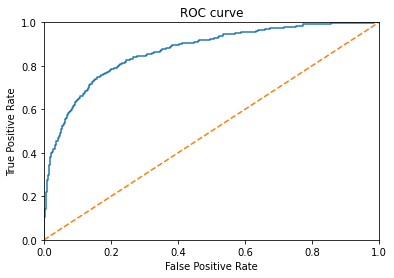

In [26]:
#plotting a AUC-ROC curve
probabilities_test = random_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, threshold = roc_curve(target_test,probabilities_one_test)
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

The AUC-ROC score for the test using random forest model is  0.86, which is higher than the random model of 0.50. An AUR-ROC score of 0.86 indicates that this a fairly good and efficient model at distinguishing between classes because it is fairly closed to a perfect score of 1.

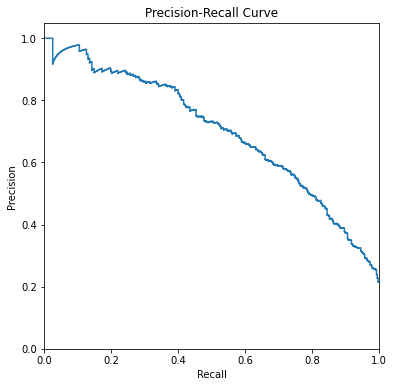

In [27]:
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_test)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

The PR curve is high, which indicates that the model is working pretty well. 

## Conclusion

Our findings are: 

1. Random forest is the best model, follows by decision tree, then logistic regression. 
2. Best F1 scores are as followed: balanced class > imbalanced class > upsampling > downsampling.
3. The balanced random forest model gives us the best f1_score and AU-ROC score at max_depth = 9. Thus this was use to perform on the test dataset
4. Final testing results in the f1 score of 0.63 and AU-ROC score of 0.86, which satifies the f1 score threshold of 0.59. Also, an indication of a good working model. 
5. ROC curve is plotted and it is higher than the random model of 0.50
6. PR curve is also plotted and it is high. 

The finding results tell us that a balanced random forest model is a good model which gives us a good f_1 score, au-roc score and curves. 